Приложение Д. Решение практической работы (Рекомендательная система)

In [3]:
!pip install neo4j matplotlib networkx

In [4]:
import warnings
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Dict

🌱 Генерация данных (Покупатели и Товары)...
✅ Данные загружены.

📊 Строим граф связей...


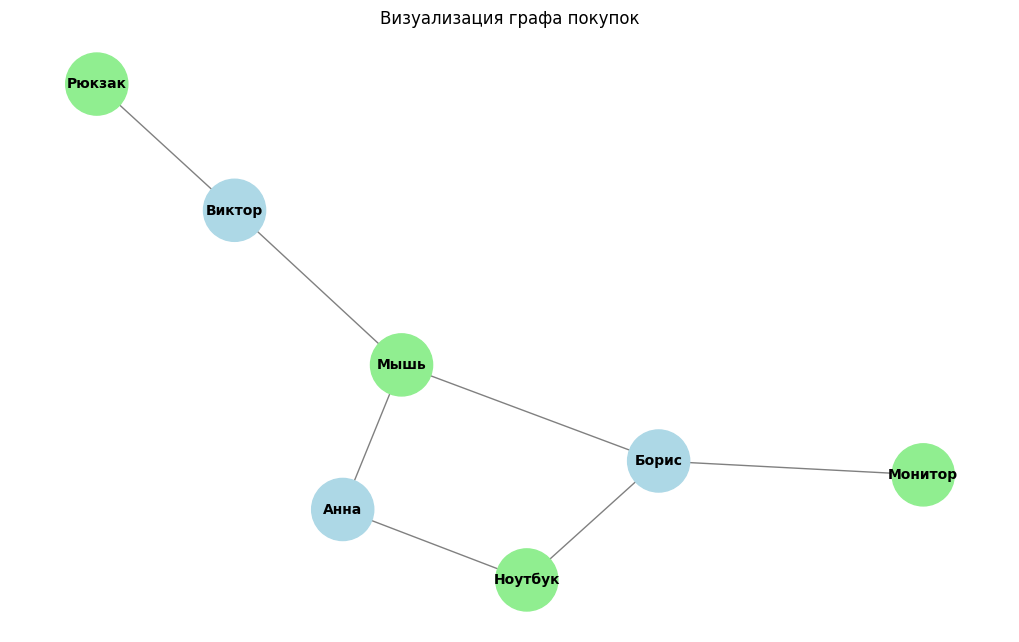


🔍 --- Анализ для пользователя: Анна ---
👉 РЕКОМЕНДУЕМ: Рюкзак (Цена: 80)
   Причина: этот товар купили ['Виктор']
👉 РЕКОМЕНДУЕМ: Монитор (Цена: 300)
   Причина: этот товар купили ['Борис']

📦 --- С товаром 'Мышь' часто покупают ---


   - Ноутбук (2 совм. покупок)
   - Рюкзак (1 совм. покупок)
   - Монитор (1 совм. покупок)

⭐ --- ТОП товаров (PageRank) ---
   1. Мышь (Score: 1.358)
   2. Ноутбук (Score: 0.926)
   3. Рюкзак (Score: 0.582)
   4. Монитор (Score: 0.537)


In [ ]:
# Подавляем технические предупреждения от Neo4j GDS для чистоты вывода
warnings.filterwarnings("ignore")

class RecommendationEngine:
    def __init__(self, uri: str, user: str, password: str):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def seed_database(self):
        """Создание тестовых данных"""
        print("🌱 Генерация данных (Покупатели и Товары)...")
        # Очистка базы перед тестом (ОСТОРОЖНО!)
        with self.driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")

        query = """
        MERGE (u1:User {name: 'Анна'})
        MERGE (u2:User {name: 'Борис'})
        MERGE (u3:User {name: 'Виктор'})

        MERGE (p1:Product {name: 'Ноутбук', price: 1000})
        MERGE (p2:Product {name: 'Мышь', price: 50})
        MERGE (p3:Product {name: 'Рюкзак', price: 80})
        MERGE (p4:Product {name: 'Монитор', price: 300})

        // Анна и Борис похожи (оба купили Ноут и Мышь)
        MERGE (u1)-[:PURCHASED]->(p1)
        MERGE (u1)-[:PURCHASED]->(p2)

        // Борис купил еще и Монитор (это будет рекомендацией)
        MERGE (u2)-[:PURCHASED]->(p1)
        MERGE (u2)-[:PURCHASED]->(p2)
        MERGE (u2)-[:PURCHASED]->(p4)

        // Виктор купил Мышь и Рюкзак
        MERGE (u3)-[:PURCHASED]->(p3)
        MERGE (u3)-[:PURCHASED]->(p2)
        """
        with self.driver.session() as session:
            session.run(query)
            print("✅ Данные загружены.")

    def get_recommendations(self, user_name: str) -> List[Dict]:
        """Коллаборативная фильтрация"""
        query = """
        MATCH (me:User {name: $name})-[:PURCHASED]->(:Product)<-[:PURCHASED]-(similar:User)
        WHERE me <> similar
        MATCH (similar)-[:PURCHASED]->(rec:Product)
        WHERE NOT EXISTS { (me)-[:PURCHASED]->(rec) }
        WITH rec, COUNT(DISTINCT similar) AS score,
             COLLECT(DISTINCT similar.name) AS recommended_by
        ORDER BY score DESC
        RETURN rec.name AS product_name, rec.price AS price, score, recommended_by
        """
        with self.driver.session() as session:
            result = session.run(query, name=user_name)
            return [dict(record) for record in result]

    def get_frequently_bought_together(self, product_name: str) -> List[Dict]:
        """Анализ корзины"""
        query = """
        MATCH (p:Product {name: $name})<-[:PURCHASED]-(u:User)-[:PURCHASED]->(other:Product)
        WHERE p <> other
        WITH other, COUNT(u) AS co_purchases
        ORDER BY co_purchases DESC
        RETURN other.name AS name, co_purchases
        """
        with self.driver.session() as session:
            result = session.run(query, name=product_name)
            return [dict(record) for record in result]

    def calculate_pagerank(self):
        """Расчет PageRank через GDS"""
        project_name = 'shop_graph'
        with self.driver.session() as session:
            # Очистка проекции если есть
            session.run(f"CALL gds.graph.drop('{project_name}', false)")

            # Создание проекции
            session.run(f"""
                CALL gds.graph.project(
                    '{project_name}',
                    ['User', 'Product'],
                    {{PURCHASED: {{orientation: 'UNDIRECTED'}}}}
                )
            """)

            # Расчет
            result = session.run(f"""
                CALL gds.pageRank.stream('{project_name}')
                YIELD nodeId, score
                WITH gds.util.asNode(nodeId) AS n, score
                WHERE n:Product
                RETURN n.name AS product, score
                ORDER BY score DESC
            """)
            return [dict(record) for record in result]

    def visualize_graph(self):
        """Визуализация графа с помощью NetworkX и Matplotlib"""
        query = "MATCH (u:User)-[r:PURCHASED]->(p:Product) RETURN u.name, p.name"
        with self.driver.session() as session:
            results = session.run(query)

            G = nx.Graph()
            for record in results:
                G.add_node(record['u.name'], type='User', color='lightblue')
                G.add_node(record['p.name'], type='Product', color='lightgreen')
                G.add_edge(record['u.name'], record['p.name'])

            plt.figure(figsize=(10, 6))
            pos = nx.spring_layout(G, seed=42)

            # Рисуем узлы разными цветами
            colors = [nx.get_node_attributes(G, 'color')[node] for node in G.nodes()]

            nx.draw(G, pos, with_labels=True, node_color=colors,
                    node_size=2000, font_size=10, font_weight='bold',
                    edge_color='gray')
            plt.title("Визуализация графа покупок")
            plt.show()

# --- ЗАПУСК ---
if __name__ == '__main__':
    # ВАШИ ДАННЫЕ ИЗ SANDBOX
    URI = "____________________"
    USER = "neo4j"
    PASS = "__________________"

    engine = RecommendationEngine(URI, USER, PASS)

    # 1. Загрузка данных
    engine.seed_database()

    # 2. Визуализация (для наглядности)
    print("\n📊 Строим граф связей...")
    engine.visualize_graph()

    # 3. Рекомендации
    print("\n🔍 --- Анализ для пользователя: Анна ---")
    recs = engine.get_recommendations('Анна')
    if not recs:
        print("Нет рекомендаций.")
    for r in recs:
        print(f"👉 РЕКОМЕНДУЕМ: {r['product_name']} (Цена: {r['price']})")
        print(f"   Причина: этот товар купили {r['recommended_by']}")

    # 4. Cross-sell
    print("\n📦 --- С товаром 'Мышь' часто покупают ---")
    cross_sell = engine.get_frequently_bought_together('Мышь')
    for item in cross_sell:
        print(f"   - {item['name']} ({item['co_purchases']} совм. покупок)")

    # 5. PageRank (Популярность)
    print("\n⭐ --- ТОП товаров (PageRank) ---")
    ranks = engine.calculate_pagerank()
    for i, r in enumerate(ranks, 1):
        print(f"   {i}. {r['product']} (Score: {r['score']:.3f})")

    engine.close()